In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
"""Test script for the game board.
"""

from __future__ import print_function
from minesweeper.msgame import MSGame
import os
import time
import random 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics

# Create baseline feature map from minesweeper grid without any data manipulation
def createBaseFeatures(x, y, grid, fillerValue= -1):
    features = []
    for i, j in [[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]]:
        newX = x + i
        newY = y + j
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:   
            if grid[newX][newY] == 11:
                features.append(0)
            else:
                features.append(grid[newX][newY])
        else:
            features.append(fillerValue)
            
    return features

# Create feautures using naive approach: sum non 11 adjacent squares and divde by 8
def createNaiveFeatures(x, y, grid, fillerValue= -1):
    features = []
    targetVal = 0
    for i, j in [[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]]:
        newX = x + i
        newY = y + j
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:
            if x == newX and y == newY:
                features.append(0)
            elif grid[newX][newY] == 11:
                features.append(0)
            else:
                features.append(grid[newX][newY])
                targetVal += 1
        else:
            features.append(fillerValue)
    
    features[4] = targetVal/8
    
    return features




# Generate dataset from all valid moves
def generateDataPoints(moves, grid, bombMap):
    data = []
    for x, y in moves:
        if isValidCell(x, y, grid):
            feats = createBaseFeatures(x, y, grid)
#             feats = createNaiveFeatures(x, y, grid)
            label = bombMap[x][y]
            data.append((feats, label))
            
    return data


# Determine if grid square has an adjacent square with value from 1-8
def isValidCell(x, y, grid):
    validVals = [i for i in range(1, 9)]
    for i, j in [[-1,-1],[-1,0],[-1,1],[0,1],[0,-1],[1,-1],[1,0],[1,1]]:
        newX = x + i
        newY = y + j
        if len(grid) > newX >= 0 and len(grid[0]) > newY >= 0:
            if grid[newX][newY] in validVals:
                return True
    return False


# Find all grid squares that can be clicked (value of 11)
def findValidMoves(grid):
    validMoves = []
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 11:
                validMoves.append([i,j])
    return validMoves

    
    
    
board_size_x = 16

board_size_y = 30

bombs = 99

iterations = 2000

dataset = []

unique = {}

for i in range(iterations):
    game = MSGame(board_size_x, board_size_y, bombs, verbose=False)
    
    while game.game_status  == 2:
        moves = findValidMoves(game.get_info_map())
        choice = random.choice(moves)
        game.playAutoMove(choice[1], choice[0])
        if game.game_status == 2:
            currentStateData = generateDataPoints(moves, game.get_info_map(), game.get_mine_map())
        
            
            for i,v in currentStateData:
                unique[tuple((tuple(i),v))] = 1

            dataset.extend(currentStateData)

        
print("Length of dataset: ", len(dataset))
print("Number of unique data points: ", len(unique.items()))

Length of dataset:  323976
Number of unique data points:  7875


In [58]:
trainSize = 0.8

trainPoint = round(trainSize * len(dataset))

X = [x[0] for x in dataset]
y = [x[1] for x in dataset]

Xtrain = X[:trainPoint]
ytrain = y[:trainPoint]

Xtest = X[trainPoint:]
ytest = y[trainPoint:]

print(np.shape(Xtrain),np.shape(ytrain),np.shape(Xtest),np.shape(ytest))

(259181, 9) (259181,) (64795, 9) (64795,)


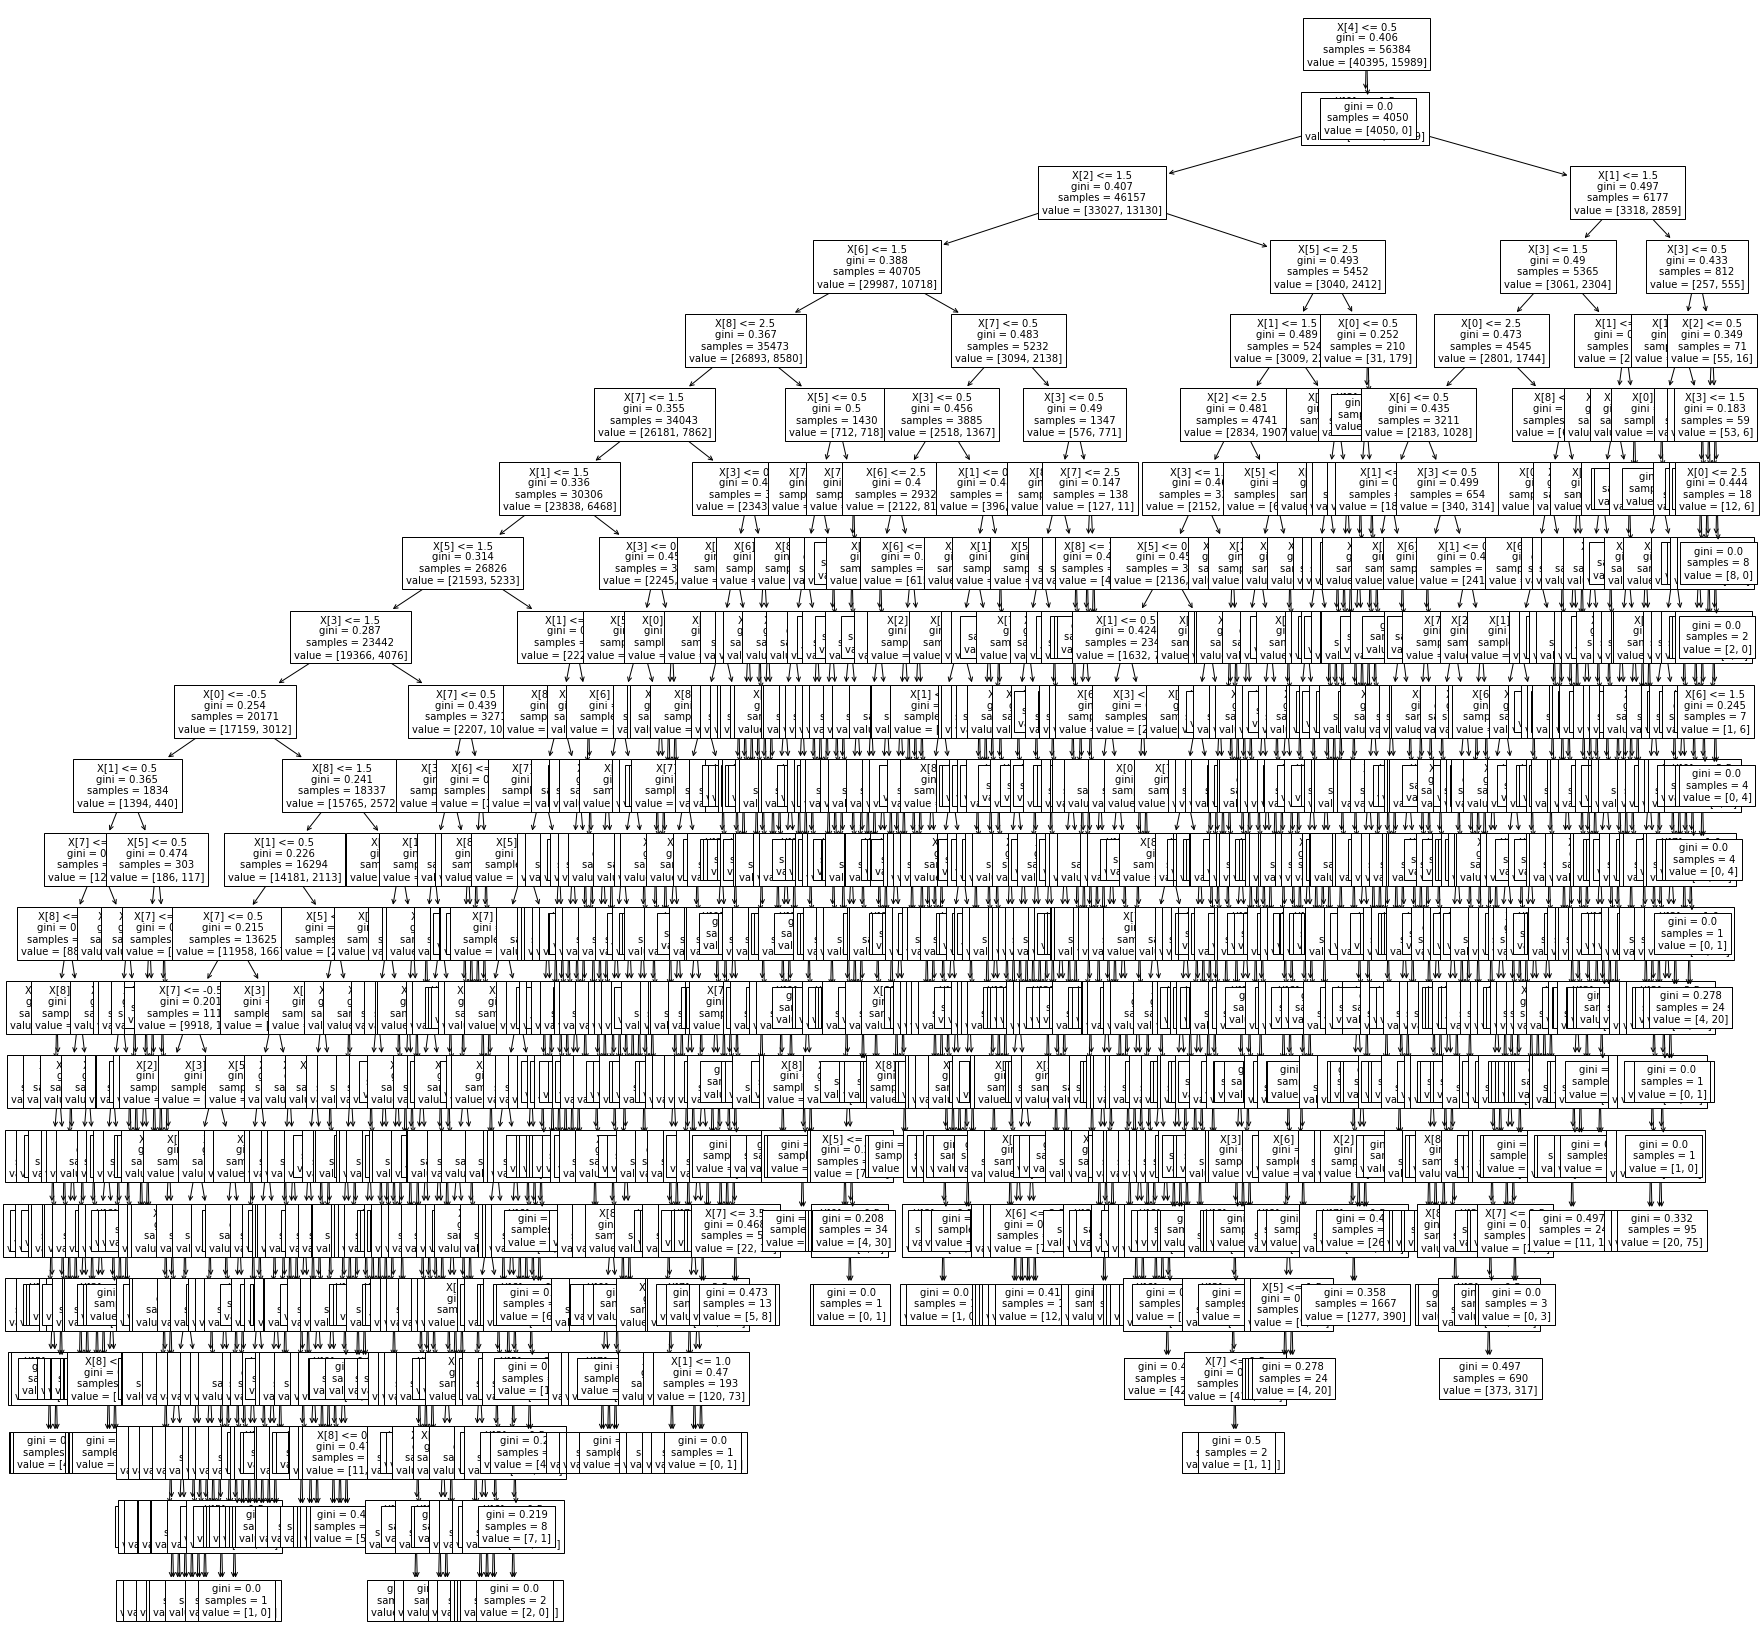

In [51]:
from matplotlib.pyplot import figure

clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)
plt.figure(figsize=(30,30))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

In [59]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf = clf.fit(Xtrain, ytrain)


In [60]:

ypred = clf.predict(Xtest)

print("Accuracy:",metrics.accuracy_score(ytest, ypred))

Accuracy: 0.7772050312524115


In [61]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import check_array
# from sklearn.tree.tree import DTYPE

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)

ypred = clf.predict_proba(Xtest)

count = 0
correct = 0
for i in range(len(ypred)):
    if ypred[i][1] == 1:
        count += 1
        if ytest[i] == 1:
            correct += 1

print(correct/count)

a = clf.predict_proba(Xtest)[:10]

for i in range(len(a)):
    print(a[i], ytest[i])


# def get_node(X):
#     return clf.tree_.apply(check_array(X, dtype=DTYPE))

# node_idx, = get_node(Xtest[:1])
# ytrain[get_node(Xtrain) == node_idx].mean()

0.9825418994413407
[0.87514253 0.12485747] 0
[0.61945946 0.38054054] 0
[1. 0.] 0
[1. 0.] 0
[0.76416442 0.23583558] 0
[0.63274336 0.36725664] 1
[0.79834508 0.20165492] 0
[0. 1.] 1
[0.73193277 0.26806723] 0
[0.7755102 0.2244898] 0


In [56]:

def simulate(board_size_x, board_size_y, bombs, model, simulations=1, printBoard=False):
    
    solved = 0
    for i in range(simulations):
        game = MSGame(board_size_x, board_size_y, bombs, verbose=False)
        if printBoard:
            print(game.get_info_map())
        while game.game_status  == 2:
            moves = findValidMoves(game.get_info_map())
            moveProbabilities = []
            for move in moves:
                feat = createBaseFeatures(move[0], move[1], game.get_info_map())
                probability = model.predict_proba([feat])
                moveProbabilities.append((move, probability[0]))
            
            moveProbabilities.sort(key=lambda x:x[1][0], reverse=True)
            
            choice, nonBombProbability = moveProbabilities[0]

            game.playAutoMove(choice[1], choice[0])
            if printBoard:
                print(game.get_info_map())
                print("move_made: ", choice[0], choice[1])
                print("non bomb probabiluty: ", nonBombProbability)
                
                if game.game_status == 1:
                    print('game won!!')
                elif game.game_status == 0:
                    print('game lost :(')
                time.sleep(1)
                print()
                
                
            if game.game_status == 1:
                solved += 1
        if printBoard:        
            print("MINE MAP")
            print(game.get_mine_map())
    
    return solved/ simulations
    
board_size_x = 9

board_size_y = 9

bombs = 15

simulations = 1


simulate(board_size_x, board_size_y, bombs, clf, simulations=simulations, printBoard=True)     

[[11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]]
[[11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [ 1 11 11 11 11 11 11 11 11]]
move_made:  8 0
non bomb probabiluty:  [1. 0.]

[[11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [ 1 11 11 11 11 11 11 11  1]]
move_made:  8 8
non bomb probabiluty:  [1. 0.]

[[11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 [11 11 11 11 11 11 11 11 11]
 

0.0